## Imports & constants

In [2]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, 
    TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy
)

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR

[09:42:56|INFO|config.py:58] PyTorch version 2.3.1 available.
[09:42:56|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-10 09:42:56.851690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 09:42:56.859208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 09:42:56.871488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 09:42:56.871527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

In [3]:
RANDOM_SEED = 123  # random reproducibility
np.random.seed(RANDOM_SEED)
BASE_CHECKPOINT = "camembert/camembert-large"
TASK_NAME = "hasrelation"
TASK_TARGET_COL = "label" # hasrelation?
TASK_INPUT_COL = "input_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}

generated_data_dir_path = os.path.join(INTERIM_DIR, "reduced_text_w_entity_bracket")
assert os.path.exists(generated_data_dir_path)
train_dir = os.path.join(generated_data_dir_path, "train")
test_dir = os.path.join(generated_data_dir_path, "test")

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_reduced_text_w_entity_bracket")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
def get_cat_var_distribution(cat_var: pd.Series) -> pd.DataFrame:
    return pd.concat(
        [cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1
    )

## Prepare the datasets for the binary text classification

### Load and process the target

In [5]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

train_df = load_csv(train_dir, index_col=0).assign(**{
        # TASK_INPUT_COL: lambda df: df[["e1_type", "e2_type", "reduced_text"]].apply(lambda row: ' | '.join(row.values.astype(str)), axis=1),
        TASK_INPUT_COL: lambda df: df["reduced_text"],
        TASK_TARGET_COL: lambda df: pd.notnull(df.relations).astype(int),
    },
)
train_df

,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text,label
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ...","Au milieu de l’[ interview ], un { incendie } ...",0
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...","Au milieu de l’{ interview }, un [ incendie ] ...",1
2,2576,2,0,CBRN_EVENT,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un incendie est ...","Au milieu de l’[ interview ], un incendie est ...",0
3,2576,0,2,GATHERING,CBRN_EVENT,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...","Au milieu de l’{ interview }, un incendie est ...",1
4,2576,2,1,CBRN_EVENT,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’interview, un [ incendie ] est ...","Au milieu de l’interview, un [ incendie ] est ...",1
...,...,...,...,...,...,...,...,...,...,...
122039,41884,11,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Au moment de sortir de la porte du magasin, Mo...","Au moment de sortir de la porte du magasin, Mo...",0
122040,41884,12,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,Au moment de sortir de la { porte } du magasin...,Au moment de sortir de la { porte } du magasin...,0
122041,41884,15,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Depuis la { fenêtre } des toilettes, monsieur ...","Depuis la { fenêtre } des toilettes, monsieur ...",0
122042,41884,17,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",['HAS_COLOR'],"Depuis la fenêtre des toilettes, monsieur Bace...","Depuis la fenêtre des toilettes, monsieur Bace...",1


In [5]:
train_df.to_parquet(os.path.join(INTERIM_DIR, "train-entities+reduced_text.parquet"), index=False)

In [6]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,95650,0.783734
1,26394,0.216266


### train-validation split

In [7]:
VALIDATION_RATE = 0.2
train_df, val_df = train_test_split(train_df, test_size=VALIDATION_RATE, shuffle=True, random_state=RANDOM_SEED, stratify=train_df[TASK_TARGET_COL])
train_df.shape, val_df.shape

((97635, 10), (24409, 10))

In [8]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,76520,0.783735
1,21115,0.216265


In [9]:
get_cat_var_distribution(val_df[TASK_TARGET_COL])

,count,proportion
label,,
0,19130,0.783727
1,5279,0.216273


### Undersampling the majority class

In [10]:
positive_train_df = train_df.query(f"{TASK_TARGET_COL}==1")
positive_train_df.shape

(21115, 10)

In [11]:
negative_train_df = train_df.query(f"{TASK_TARGET_COL}==0")
negative_train_df.shape

(76520, 10)

In [12]:
# balance classes
# train_df = pd.concat([positive_train_df, negative_train_df.sample(positive_train_df.shape[0])], axis=0)
# train_df.shape

## Create the tokenized datasets for model input

### init the tokenizer

In [13]:
# Hyperparameters
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<", ">", "{", "}"] + [
    f"{entity_class}" for entity_class in entity_classes
]
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens, len(tokenizer)

(59, 32063)

### init the train-valid datasets from dataframe

In [14]:
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds = Dataset.from_pandas(val_df, preserve_index=False)
task_datasets = DatasetDict({"train": train_ds, "validation": val_ds})
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [15]:
task_datasets["train"][0]

{'text_index': 3653,
 'e1_id': 10,
 'e2_id': 4,
 'e1_type': 'GROUP_OF_INDIVIDUALS',
 'e2_type': 'PLACE',
 'text': "Le 13 mars 2020, une guerre civile a éclaté opposant les citoyens de l'[ Est ] de Londres à ceux du Sud. Les citoyens de l'[ Est ] étaient contre l'installation des citoyens du Sud sur leur territoire. Ils ont utilisé du carburant pour brûler des pneus de voiture et étaient armés de bâtons. Cette guerre a blessé au total 25 personnes. Les victimes étaient des { civils } et des employés de PINS, une société de sécurité. Monsieur Kina Evans était parmi les victimes, il a pu être identifié grâce à sa carte d'identité nationale et son téléphone.",
 'relations': None,
 'reduced_text': "Le 13 mars 2020, une guerre civile a éclaté opposant les citoyens de l'[ Est ] de Londres à ceux du Sud. Les citoyens de l'[ Est ] étaient contre l'installation des citoyens du Sud sur leur territoire. Les victimes étaient des { civils } et des employés de PINS, une société de sécurité.",
 'input

In [16]:
task_datasets["train"][1]

{'text_index': 51462,
 'e1_id': 8,
 'e2_id': 11,
 'e1_type': 'GROUP_OF_INDIVIDUALS',
 'e2_type': 'TIME_EXACT',
 'text': '[ Ce matin ], au Luxembourg, une jeune femme nommée Defne Li, présidente de "l’Ordre des Consommateurs Éclairés", a effectué un communiqué à la télévision. Depuis de nombreuses années, l’association s’est donné pour mission d\'informer les consommateurs afin de leur assurer une alimentation de qualité. Un récent rapport de l\'association a montré que plusieurs marques de glaces et de sorbets de la place étaient contaminées par l\'oxyde d\'éthyle, un pesticide hautement cancérigène qui représente donc un danger pour la santé. Defne Li a invité les { personnes } ayant acheté ces aliments contaminés à se rendre dans les supermarchés avec les tickets d\'achat pour se faire rembourser.',
 'relations': None,
 'reduced_text': '[ Ce matin ], au Luxembourg, une jeune femme nommée Defne Li, présidente de "l’Ordre des Consommateurs Éclairés", a effectué un communiqué à la télév

### Tokenize the datasets

In [17]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True)

# We’re using batched=True in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately
# This is way faster
# Source https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# columns are removed because DataCollatorWithPadding doesn't support any other columns than the ones produced by the tokenizer (or non tensors)
tokenized_datasets = task_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/97635 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 24409
    })
})

In [18]:
# tokenized_datasets.column_names

In [19]:
type(tokenized_datasets["train"][1]['attention_mask'])

list

### Token numbers distribution

In [20]:
from typing import Any, Dict

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])


def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example[TASK_INPUT_COL])}


tokenized_datasets = tokenized_datasets.map(count_token_in_dataset_element)
tokenized_datasets

Map:   0%|          | 0/97635 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 24409
    })
})

In [21]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(tokenized_datasets[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in tokenized_datasets.keys()
    }
)
split2ntokens_df.describe()

validation: 100%|██████████| 24409/24409 [00:01<00:00, 12948.86it/s]


,train,validation
count,97635.000000,24409.000000
mean,63.551728,63.261502
std,29.399469,29.189710
min,10.000000,11.000000
25%,43.000000,42.000000
50%,58.000000,58.000000
75%,78.000000,78.000000
max,299.000000,266.000000


<Axes: >

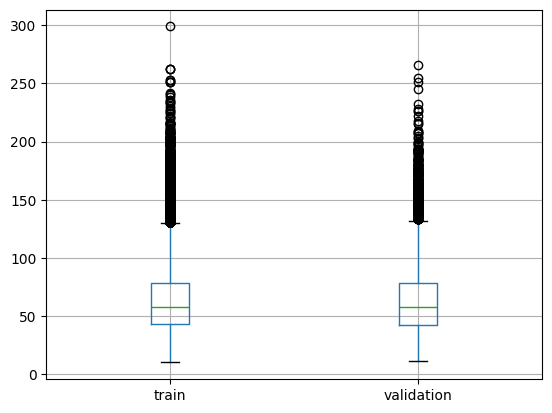

In [22]:
split2ntokens_df.boxplot()

In [23]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 200)

Filter:   0%|          | 0/97635 [00:00<?, ? examples/s]

Dataset({
    features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
    num_rows: 93
})

In [24]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == 19)[0]['input_text']

Filter:   0%|          | 0/97635 [00:00<?, ? examples/s]

"De nombreuses < personnes > ont été calcinées au cours de l'incendie."

In [25]:
# tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 300)[0]['input_text']

### Test the batch-level padding with a data collator

In [26]:
samples = tokenized_datasets.remove_columns(task_datasets["train"].column_names)["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[68, 75, 46, 117, 98, 96, 105, 48]

In [27]:
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 97635
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 117]),
 'attention_mask': torch.Size([8, 117]),
 'n_tokens': torch.Size([8])}

## Fine-tuning a model with the Trainer API

### Compute the weight of classes to handle imbalance

In [29]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
n_examples = train_df.shape[0]
n_classes = train_df[TASK_TARGET_COL].nunique()
def compute_class_weights(lbl_df: pd.DataFrame) -> pd.Series:
    return get_cat_var_distribution(lbl_df[TASK_TARGET_COL]).reset_index(drop=False)["count"].apply(lambda x: (1 / x) * (n_examples / n_classes)).rename("weight")
class_weights_df = compute_class_weights(train_df)
class_weights_df

0    0.637970
1    2.311982
Name: weight, dtype: float64

In [30]:
class_weights = class_weights_df.values.tolist()
class_weights

[0.6379704652378463, 2.311982003315179]

In [31]:
pd.concat([get_cat_var_distribution(train_df[TASK_TARGET_COL]), class_weights_df], axis=1)

,count,proportion,weight
0,76520,0.783735,0.637970
1,21115,0.216265,2.311982


### Init the model

In [32]:
n_classes = train_df[TASK_TARGET_COL].nunique()
print(f"{n_classes=}")
model = AutoModelForSequenceClassification.from_pretrained(BASE_CHECKPOINT, num_labels=n_classes)
model.resize_token_embeddings(len(tokenizer))

n_classes=2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32063, 1024, padding_idx=1)

In [33]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32063, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_feature

### Init the trainer and launch the training

Source: https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances#69087153

1. Use `load_best_model_at_end = True` (EarlyStoppingCallback() requires this to be True).
2. `evaluation_strategy = 'steps'` or IntervalStrategy.STEPS instead of 'epoch'.
3. `eval_steps = 50` (evaluate the metrics after N steps).
4. `metric_for_best_model = 'f1'`

In [34]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-checkpoints"),
    per_device_train_batch_size=8,    
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    eval_strategy=IntervalStrategy.STEPS, # steps
    eval_steps = 5000, # Evaluation and Save happens every 50 steps
    learning_rate=2e-6,
    weight_decay=0.01,
    save_strategy=IntervalStrategy.STEPS,
    save_steps=5000,
    logging_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-tensorboard"),
    save_total_limit = 1, # Only last 2 models are saved. Older ones are deleted
    push_to_hub=False,
    metric_for_best_model = 'f1',
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
)

class CustomTrainer(Trainer):    
    def compute_loss(self, model, inputs, return_outputs=False):
        """customize the loss to leverage class weights"""
        labels = inputs.get("labels")
        # print(labels)
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # print(logits)
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=4)],
)

# trainer.train(resume_from_checkpoint=True)

## Launch training

In [35]:
trainer.callback_handler.callbacks[-2].__dict__

{'early_stopping_patience': 4,
 'early_stopping_threshold': 0.0,
 'early_stopping_patience_counter': 0}

In [36]:
trainer.train(resume_from_checkpoint=os.path.exists(training_args.output_dir))

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
5000,0.477700,0.482938,0.872793,0.808647,0.832985,0.819649
10000,0.452500,0.489954,0.894916,0.847936,0.837910,0.842759
15000,0.412100,0.384919,0.891352,0.832744,0.867387,0.847912
20000,0.417700,0.338020,0.898767,0.843712,0.873215,0.856979
25000,0.374900,0.421148,0.899136,0.842519,0.882297,0.859665
30000,0.370300,0.478717,0.910607,0.866024,0.872882,0.869381
35000,0.358800,0.490959,0.915605,0.876470,0.873671,0.875059
40000,0.325000,0.417820,0.905404,0.850795,0.891577,0.868394
45000,0.292900,0.443585,0.911057,0.860141,0.892303,0.874562
50000,0.269100,0.551102,0.916506,0.874097,0.882612,0.878246


TrainOutput(global_step=140000, training_loss=0.24677674966539656, metrics={'train_runtime': 43408.0694, 'train_samples_per_second': 112.462, 'train_steps_per_second': 14.058, 'total_flos': 2.2802608174848125e+17, 'train_loss': 0.24677674966539656, 'epoch': 11.470708725931996})

# Evaluate

In [37]:
trainer.state.best_metric

0.8874796940317304

In [38]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

'data/defi-text-mine-2025/models/hasrelation-byTrainerAPI-checkpoints/checkpoint-120000'

In [39]:
trainer._load_best_model()

## Global evaluation train vs validation

In [ ]:
# trainer.evaluate(tokenized_datasets["train"])

In [ ]:
# trainer.evaluate(tokenized_datasets["validation"])

## Get the labels

In [41]:
train_pred_output = trainer.predict(tokenized_datasets["train"], metric_key_prefix="train")

In [42]:
train_y_pred = torch.sigmoid(torch.from_numpy(train_pred_output.predictions)).argmax(axis=1)
train_y_pred

tensor([0, 0, 0,  ..., 1, 0, 0])

In [43]:
val_pred_output = trainer.predict(tokenized_datasets["validation"], metric_key_prefix="validation")

In [44]:
val_y_pred = torch.sigmoid(torch.from_numpy(val_pred_output.predictions)).argmax(axis=1)
val_y_pred

tensor([1, 0, 0,  ..., 0, 0, 0])

## Global metrics

In [45]:
train_pred_output.metrics

{'train_loss': 0.03935796767473221,
 'train_accuracy': 0.9922568750960209,
 'train_precision': 0.9853210944914224,
 'train_recall': 0.992093924639656,
 'train_f1': 0.9886585070838638,
 'train_runtime': 921.6686,
 'train_samples_per_second': 105.933,
 'train_steps_per_second': 13.242}

In [46]:
val_pred_output.metrics

{'validation_loss': 0.7264977097511292,
 'validation_accuracy': 0.9224876070301938,
 'validation_precision': 0.8816240934176747,
 'validation_recall': 0.8937663331229768,
 'validation_f1': 0.8874796940317304,
 'validation_runtime': 214.5023,
 'validation_samples_per_second': 113.794,
 'validation_steps_per_second': 14.228}

## Classification report

In [47]:
print(classification_report(y_true=train_pred_output.label_ids, y_pred=train_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     76520
           1       0.97      0.99      0.98     21115

    accuracy                           0.99     97635
   macro avg       0.99      0.99      0.99     97635
weighted avg       0.99      0.99      0.99     97635



In [48]:
print(classification_report(y_true=val_pred_output.label_ids, y_pred=val_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     19130
           1       0.81      0.84      0.82      5279

    accuracy                           0.92     24409
   macro avg       0.88      0.89      0.89     24409
weighted avg       0.92      0.92      0.92     24409



## Confusion matrix

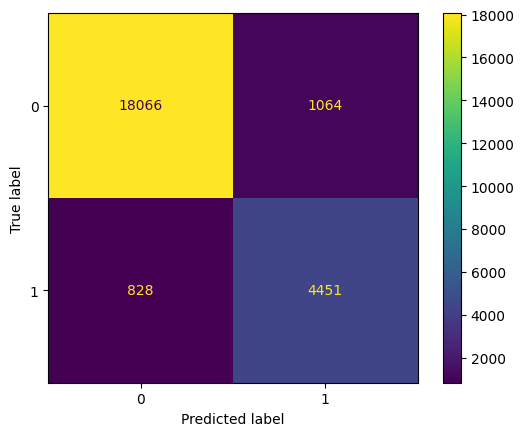

In [49]:
cm = confusion_matrix(y_true=val_pred_output.label_ids, y_pred=val_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

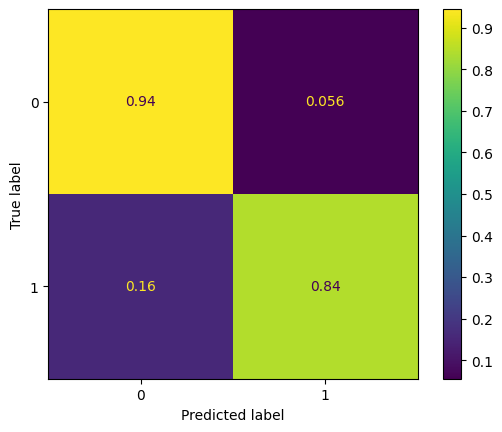

In [50]:
cm = confusion_matrix(y_true=val_pred_output.label_ids, y_pred=val_y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Error analysis

In [51]:
from transformers import pipeline

classifier = pipeline("text-classification", model=best_ckpt_path, device="cuda")

In [52]:
tokenized_datasets["validation"].take(10)

Dataset({
    features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
    num_rows: 10
})

In [53]:
trainer.predict(tokenized_datasets["validation"].take(10))

PredictionOutput(predictions=array([[-4.5797715,  5.343979 ],
       [ 4.227528 , -5.0170765],
       [ 4.9561553, -5.6975284],
       [ 5.0906577, -5.872164 ],
       [ 4.3627715, -5.0298867],
       [ 4.9506693, -5.7980747],
       [ 2.4918609, -3.1229084],
       [ 4.956315 , -5.7459497],
       [ 4.299241 , -5.076226 ],
       [ 4.977216 , -5.7909646]], dtype=float32), label_ids=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), metrics={'test_loss': 0.0003177729086019099, 'test_accuracy': 1.0, 'test_precision': 1.0, 'test_recall': 1.0, 'test_f1': 1.0, 'test_runtime': 0.2749, 'test_samples_per_second': 36.375, 'test_steps_per_second': 7.275})

In [54]:
train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

,input_text,label,relations
86783,"En [ janvier 2021 ], un affrontement politique...",0,NaN
36231,"Ahmed Ludovic, candidat à l'{ élection préside...",1,"['START_DATE', 'END_DATE']"
109415,[ Trois jours après ] la proclamation des résu...,0,NaN
110743,Une émeute a eu lieu [ aujourd'hui ] à Athènes...,0,NaN
64339,"Le [ 26 juillet 2013 ], les { élections présid...",0,NaN
65302,"Le [ 9 juin 2007 ], une élection de chef de pr...",1,"['START_DATE', 'END_DATE']"
68606,"Suite aux { élections } du 4 mai 2018, M. Luis...",0,NaN
25072,"Un rassemblement illégal a été organisé, le [ ...",0,NaN
17631,Un concours de costumes a eu lieu à New York l...,1,"['START_DATE', 'END_DATE']"
85901,Les résultats définitifs des { élections } lég...,0,NaN


In [55]:
classifier(train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")["input_text"].values.tolist())

[{'label': 'LABEL_0', 'score': 0.9999501705169678},
 {'label': 'LABEL_1', 'score': 0.9997116923332214},
 {'label': 'LABEL_0', 'score': 0.9991756081581116},
 {'label': 'LABEL_0', 'score': 0.999955415725708},
 {'label': 'LABEL_0', 'score': 0.9995123147964478},
 {'label': 'LABEL_1', 'score': 0.9999228715896606},
 {'label': 'LABEL_0', 'score': 0.9999476671218872},
 {'label': 'LABEL_0', 'score': 0.9999750852584839},
 {'label': 'LABEL_1', 'score': 0.9998880624771118},
 {'label': 'LABEL_0', 'score': 0.9999561309814453},
 {'label': 'LABEL_1', 'score': 0.9998435974121094},
 {'label': 'LABEL_1', 'score': 0.9999229907989502},
 {'label': 'LABEL_0', 'score': 0.9998916387557983},
 {'label': 'LABEL_1', 'score': 0.9999223947525024},
 {'label': 'LABEL_0', 'score': 0.9999772310256958},
 {'label': 'LABEL_1', 'score': 0.9997922778129578}]

In [56]:
classifier(val_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")["input_text"].values.tolist())

[{'label': 'LABEL_0', 'score': 0.9999785423278809},
 {'label': 'LABEL_1', 'score': 0.9996784925460815},
 {'label': 'LABEL_1', 'score': 0.9998602867126465},
 {'label': 'LABEL_1', 'score': 0.9995984435081482},
 {'label': 'LABEL_1', 'score': 0.9998108744621277}]

In [57]:
val_df[["input_text", "label", "relations"]].iloc[:10]

,input_text,label,relations
33655,Une explosion s'est accidentellement produite ...,1,['WEIGHS']
27702,Selon les informations du { Service des premie...,0,NaN
56473,"La police est arrivée rapidement, après avoir ...",0,NaN
32075,"Madame Anna Laura Sauvage, présidente de l’ass...",0,NaN
118260,"Le 9 décembre 2016, le gouvernement [ sud-afri...",0,NaN
67569,"Le [ 15 mars 2015 ] à Berlin, l'organisation s...",0,NaN
36047,"Le 12 janvier 2022, une vingtaine d’étudiants ...",0,NaN
87030,Le bilan des victimes n'a pas encore été établ...,0,NaN
93646,Le { chef de l'État } était également présent ...,0,NaN
108589,"Le 16 juin 2022, une trentaine de manifestants...",0,NaN


In [58]:
classifier(val_ds["input_text"][:10])

[{'label': 'LABEL_1', 'score': 0.9999510049819946},
 {'label': 'LABEL_0', 'score': 0.9999033212661743},
 {'label': 'LABEL_0', 'score': 0.999976396560669},
 {'label': 'LABEL_0', 'score': 0.9999827146530151},
 {'label': 'LABEL_0', 'score': 0.999916672706604},
 {'label': 'LABEL_0', 'score': 0.9999785423278809},
 {'label': 'LABEL_0', 'score': 0.9963696002960205},
 {'label': 'LABEL_0', 'score': 0.9999774694442749},
 {'label': 'LABEL_0', 'score': 0.9999152421951294},
 {'label': 'LABEL_0', 'score': 0.9999788999557495}]

In [59]:
train_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

,input_text,label,relations
86783,"En [ janvier 2021 ], un affrontement politique...",0,NaN
36231,"Ahmed Ludovic, candidat à l'{ élection préside...",1,"['START_DATE', 'END_DATE']"
109415,[ Trois jours après ] la proclamation des résu...,0,NaN
110743,Une émeute a eu lieu [ aujourd'hui ] à Athènes...,0,NaN
64339,"Le [ 26 juillet 2013 ], les { élections présid...",0,NaN
65302,"Le [ 9 juin 2007 ], une élection de chef de pr...",1,"['START_DATE', 'END_DATE']"
68606,"Suite aux { élections } du 4 mai 2018, M. Luis...",0,NaN
25072,"Un rassemblement illégal a été organisé, le [ ...",0,NaN
17631,Un concours de costumes a eu lieu à New York l...,1,"['START_DATE', 'END_DATE']"
85901,Les résultats définitifs des { élections } lég...,0,NaN


In [60]:
val_df.query("e1_type=='ELECTION' & e2_type=='TIME_EXACT'")[["input_text", "label", "relations"]]

,input_text,label,relations
67569,"Le [ 15 mars 2015 ] à Berlin, l'organisation s...",0,NaN
109413,[ Trois jours après ] la proclamation des résu...,0,NaN
65301,"Le [ 9 juin 2007 ], une { élection } de chef d...",1,"['START_DATE', 'END_DATE']"
63046,"Le [ 26 août 2013 ], les { élections président...",1,"['START_DATE', 'END_DATE']"
121356,Une { élection } de député avait eu lieu à Par...,1,"['START_DATE', 'END_DATE']"


In [61]:
train_df.loc[68593][["input_text", "label", "relations"]].values

array(['Suite aux { élections } du [ 4 mai 2018 ], M. Luis-Miguel Hassan a été { élu } à la majorité absolue nouveau président du Rwanda.',
       1, "['START_DATE', 'END_DATE']"], dtype=object)

In [62]:
train_df.loc[20455][["input_text", "label", "relations"]].values

array(['Les résultats des { élections municipales } en Serbie ont été annoncés dans la [ nuit du 7 octobre 2021 ].',
       1, "['END_DATE']"], dtype=object)

In [63]:
val_df.loc[65301][["input_text", "label", "relations"]].values

array(['Le [ 9 juin 2007 ], une { élection } de chef de projet a eu lieu au sein de l\'association des "Vétérans de la planète" à Londres.',
       1, "['START_DATE', 'END_DATE']"], dtype=object)

In [64]:
val_df.loc[67569][["input_text", "label", "relations"]].values

array(["Le [ 15 mars 2015 ] à Berlin, l'organisation socialiste nationale a organisé un grand meeting en vue des { élections présidentielles }.",
       0, nan], dtype=object)

In [65]:
val_df.loc[109413][["input_text", "label", "relations"]].values

array(['[ Trois jours après ] la proclamation des résultats des { élections } présidentielles, une partie de la population à Londres est descendue dans les rues pour manifester son désaccord.',
       0, nan], dtype=object)

In [66]:
val_ds["input_text"][5]

"Le [ 15 mars 2015 ] à Berlin, l'organisation socialiste nationale a organisé un grand meeting en vue des { élections présidentielles }."

In [67]:
classifier(val_ds["text"][5])

[{'label': 'LABEL_0', 'score': 0.9999773502349854}]

In [68]:
val_df[TASK_TARGET_COL].iloc[:10]

33655     1
27702     0
56473     0
32075     0
118260    0
67569     0
36047     0
87030     0
93646     0
108589    0
Name: label, dtype: int64

In [69]:
val_ds["input_text"]

['Une explosion s\'est accidentellement produite dans un entrepôt de l\'usine gouvernementale "Nitrate plus" qui contenait [ plusieurs tonnes ] de { nitrate d\'ammonium }.',
 "Selon les informations du { Service des premiers secours }, «\xa0les deux [ victimes ] et le pilote étaient les seuls occupants de l'appareil\xa0».",
 "La police est arrivée rapidement, après avoir reçu un appel téléphonique des responsables de l'{ université }, pour repousser les étudiants à l'intérieur du campus universitaire et rétablir la circulation des [ voitures ] et des piétons.",
 'Madame Anna Laura Sauvage, présidente de l’association « one hand » à Mexico, a été agressée [ hier matin ], dans sa voiture, par des hommes portant une cagoule. D’après son témoignage, les voyous l’ont menacée avec un { pistolet } sur la tête.',
 'Le 9 décembre 2016, le gouvernement [ sud-africain ] a été renversé par des mercenaires de l\'entreprise de sécurité privée "Blackywall anciens militaires". Le chef de l\'État a été

In [70]:
val_ds[0]

{'text_index': 2484,
 'e1_id': 11,
 'e2_id': 19,
 'e1_type': 'MATERIEL',
 'e2_type': 'WEIGHT',
 'text': 'Un drame s\'est produit cette nuit à Pretoria, une ville sud-africaine située à la latitude 25°44′41″ Sud. Une explosion s\'est accidentellement produite dans un entrepôt de l\'usine gouvernementale "Nitrate plus" qui contenait [ plusieurs tonnes ] de { nitrate d\'ammonium }. Cela a entraîné d\'importants dégâts matériels mais aussi humains. Herminia Sauvage, une femme de ménage qui balayait et passait la serpillière dans les locaux de l\'usine au moment des faits, a été projetée et s\'est retrouvée au milieu de ses seaux, de détergents et de brosses qu\'elle utilisait pour faire le ménage. Herminia Sauvage ainsi qu\'une dizaine d\'employés de l\'usine ont été grièvement blessés. Certains souffraient notamment de difficultés respiratoires et de lésions cutanées.',
 'relations': "['WEIGHS']",
 'reduced_text': 'Une explosion s\'est accidentellement produite dans un entrepôt de l\'usin

In [71]:
print(samples['input_ids'][2])

[5, 2092, 18, 227, 2603, 88, 1779, 1787, 19, 402, 18784, 7774, 37, 298, 7, 12, 956, 10, 1900, 7, 396, 8, 18, 32006, 581, 32007, 7, 15, 9, 926, 321, 24089, 26, 121, 500, 88, 4332, 19, 26969, 11, 63, 20076, 11, 5765, 10, 6]


In [72]:
tokenizer.decode(samples['input_ids'][0])

"<s> Le 13 mars 2020, une guerre civile a éclaté opposant les citoyens de l'[ Est ] de Londres à ceux du Sud. Les citoyens de l'[ Est ] étaient contre l'installation des citoyens du Sud sur leur territoire. Les victimes étaient des{ civils} et des employés de PINS, une société de sécurité.</s>"

In [73]:
tokenizer.decode(samples['input_ids'][1])

'<s> [ Ce matin ], au Luxembourg, une jeune femme nommée Defne Li, présidente de "l’Ordre des Consommateurs Éclairés", a effectué un communiqué à la télévision. Defne Li a invité les{ personnes} ayant acheté ces aliments contaminés à se rendre dans les supermarchés avec les tickets d\'achat pour se faire rembourser.</s>'

In [74]:
tokenizer.decode(samples['input_ids'][2])

'<s> Toutes les personnes présentes ont dû porter des [ masques ] au cours de la visite. Avant de partir, les{ membres} de l’association “Santé pour tous” ont offert des peluches aux nourrissons malades.</s>'